In [ ]:
try:
  import pennylane as qml
  from pennylane import numpy as np
except ImportError:
  %pip install pennylane
  import pennylane as qml
  from pennylane import numpy as np

import matplotlib.pyplot as plt
from scipy.optimize import minimize

import math
import random

# Exception for terminating the minimization
class GammaCondition(Exception):
    pass

class VQLS_Pennylane():

  # Instantiate the VQLS with a number of qubits, and a mode that determines
  # the matrix being used
  def __init__(self,
               n=3,
               mode='Ising',
               backend_type=0,
               shots=10**6,
               eps=0.01,
               method='L-BFGS-B',
               cond=20,
               w=None,
               print_circ=False):

    # n = number of qubits
    if n > 1 and n <= 50:
      self.n = n
      print("n=" + str(self.n))
    else:
      self.n = 3
      print("Number of qubits out of bounds. Defaulting to n=3")

    # 0: ising matrix
    # 1: poisson matrix
    if mode == 'Poisson' or mode == 'Ising':
      self.mode = 0 if mode == 'Ising' else 1
      print("Ising QLSP" if self.mode == 0 else "Poisson Matrix")
    else:
      self.mode = 0
      print("Mode must be Poisson or Ising. Defaulting to Ising QLSP.")

    # Only use the condition number in mode 0
    if self.mode == 0:
      if cond <= 200 and cond >= 10:
        self.cond = cond
        print("Cond = " + str(self.cond))
      else:
        print("Condition number out of bounds. Please try again.")
    else:
      print("Cond = " + str(18.139))

    # Set initial weights, if not already given
    if w is None:
      self.w = 0.001 * np.random.randn(self.n**2)
    else:
      self.w = w

    # Setting ancilla index
    self.anc = self.n

    # Setting shots
    self.shots = shots

    # Store eps
    self.eps = eps
    print("Eps = " + str(self.eps))

    # Store method
    self.method = method
    print("Method = " + str(method))

    # Define max iterations
    self.max_iter = 1000

    # Initialize cost history
    self.cost_history = []

    # Initialize result
    self.out = None

    # Setting toggle for printing circuits
    self.print_circ = print_circ

    # Setting the coefficient matrix
    if self.mode == 0:
      if self.n == 3:
        self.c = [0.509676, 0.677043, 0.7364305, 0.7668486, 0.7853381, 0.7977654, 0.8066921, 0.81341465, 0.81865975, 0.82286616, 0.82631470, 0.82919322, 0.83163227, 0.83372536, 0.83554122, 0.83713151, 0.838535800, 0.839784920, 0.840903240, 0.841910281]
      elif self.n == 4:
        self.c = [0.6936, 0.4461, 0.3693, 0.3319, 0.3098, 0.2951, 0.2847, 0.2770, 0.2710, 0.2662, 0.2622, 0.2590, 0.2562, 0.2539, 0.2518, 0.2500, 0.2485, 0.2471, 0.2458, 0.2447]

    # 0: Lightning Qubit
    if backend_type == 0:
      self.dev_mu = qml.device('lightning.qubit', wires=self.n+1)
      self.dev_x = qml.device('lightning.qubit', wires=self.n, shots=self.shots)

  def __str__(self):
    if self.out:
      print("Completed")
    else:
      print("Not yet run.")
    # print a status?

  def log_cost(self, x):
    self.cost_history.append(self.cost)
    print("Logging cost: " + str(self.cost))
    if self.cost <= self.gamma:
      raise GammaCondition

  # Used to define a matrix that represents the Ising Problem, which can be used
  # as a benchmark for the VQLS. The default
  def ising_matrix(self, zeta=0.1, eta=0.1, J=0.1):
    # Condition numbers when n = 3
    eta_c_all = self.c
    cond_all = [x for x in range(10, 210, 10)]

    cond_ind = int(self.cond/10) - 1
    eta = eta_c_all[cond_ind]
    self.c = [1/zeta for x in range(self.n)] + [J/zeta for x in range(self.n-1)] + [eta/zeta]
    self.matrix = [[2 if x == i else 0 for i in range(self.n)] for x in range(self.n)] +\
            [[1 if x == i or x+1 == i else 0 for i in range(self.n)] for x in range(self.n-1)] +\
            [[0 for x in range(self.n)]]
    return self

  def poisson_matrix_3(self):
    self.c = [2, -1, -0.5, 0.25, -0.25, -0.25, -0.5, 0.25]
    self.matrix = [[0, 0, 0], [0, 0, 2], [0, 2, 2], [2, 2, 2], [3, 3, 2], [3, 2, 3], [0, 3, 3], [2, 3, 3]]
    self.cond = 18.139
    return self

  def U_b(self):
    for idx in range(self.n):
      qml.Hadamard(wires=idx)
    return self

  def CA_exp(self, gate_type):
    for i in range(len(gate_type)):
      if gate_type[i] == 1:
        qml.CZ(wires=[self.anc, i])
      elif gate_type[i] == 2:
        qml.CNOT(wires=[self.anc, i])
      elif gate_type[i] == 3:
        qml.CY(wires=[self.anc, i])
    return self

  def CA(self, idx):
    self.CA_exp(self.matrix[idx])
    return self

  def variational_block(self, weights):

    # Require all number of layers to equal the number of qubits (for the
    # experimental variable hardware ansatz)
    if len(weights) == self.n ** 2:
      # Apply the b state
      self.U_b()

      # Using n layers for variational ansatz
      for layer in range(self.n):
        # Layer of rotation gates
        for idx, element in enumerate(weights[layer*self.n:(layer+1)*self.n]):
          qml.RY(element, wires=idx)

        # Applying entanglement layer to all but the last layer
        if layer < (self.n-1):
          for sec_ind in range(self.n):
            if layer != sec_ind:
              qml.CNOT(wires=[layer, sec_ind])

    else:
      print("Insufficient weights.")
    return self

  def local_hadamard_test(self, weights, l=None, lp=None, j=None, part=None):
    @qml.qnode(self.dev_mu, interface="autograd")
    def _local_hadamard_test(weights, l=None, lp=None, j=None, part=None):

      qml.Hadamard(wires=self.anc)

      if part.lower() == 'im':
        qml.PhaseShift(-np.pi / 2, wires=self.anc)

      self.variational_block(weights)

      self.CA(l)

      self.U_b()

      if j != -1:
        qml.CZ(wires=[self.anc, j])

      self.U_b()

      self.CA(lp)

      qml.Hadamard(wires=self.anc)

      return qml.expval(qml.PauliZ(wires=self.anc))
    if self.print_circ:
      plot = qml.draw_mpl(_local_hadamard_test)(weights, l, lp, j, part)
    return _local_hadamard_test(weights, l, lp, j, part)

  def mu(self, weights, l=None, lp=None, j=None):
    mu_real = self.local_hadamard_test(weights, l=l, lp=lp, j=j, part='Re')
    mu_imag = self.local_hadamard_test(weights, l=l, lp=lp, j=j, part='Im')

    return mu_real + 1.0j * mu_imag

  def psi_norm(self, weights):

    norm = 0.0

    for l in range(0, len(self.c)):
      for lp in range(0, len(self.c)):
        norm += self.c[l] * np.conj(self.c[lp]) * self.mu(weights, l, lp, j=-1)

    return abs(norm)

  def cost_loc(self, weights):

    mu_sum = 0.0

    for l in range(0, len(self.c)):
      for lp in range(0, len(self.c)):
        for j in range(0, self.n):
          mu_sum += self.c[l] * np.conj(self.c[lp]) * self.mu(weights, l, lp, j=j)

    mu_sum = abs(mu_sum)

    self.cost = 0.5 - 0.5 * mu_sum / (self.n * self.psi_norm(weights))

    return self.cost

  # Meant to run the VQLS entirely
  def run(self):

    if self.mode == 0:
      self.ising_matrix()
    elif self.mode == 1:
      self. poisson_matrix_3()

    self.gamma = (self.eps**2)/(self.n * (self.cond**2))
    print("Target = " + str(self.gamma))

    try:
      self.out = minimize(self.cost_loc, x0=self.w, method=self.method, callback=self.log_cost)
      met_gamma = (self.out.fun <= self.gamma)
    except GammaCondition:
      met_gamma = True

    if met_gamma:
      print("Gamma constraint reahed!")
    else:
      print("GAMMA CONSTRAINT NOT REACHED.")

    # Return a RunResult object so the user has an easier time of accessing results
    return RunResult(self.cost_history,
                     self.w,
                     self.gamma,
                     self.cost,
                     len(self.cost_history),
                     self.eps,
                     self.method,
                     self.cond,
                     self.n
                     )

# RunResult allows the user to access the results of the run.
class RunResult():

  def __init__(self,
               cost_history, # Cost history of run
               weights, # Optimized weights
               targ_gamma, # Target gamma
               res_gamma, # Final gamma
               nit, # Number of iterations
               eps, # Initial eps used
               method, # Method for optimization
               cond, # Condition number of matrix problem
               n # Number of qubits
               ):
    self.cost_history = cost_history
    self.weights = weights
    self.targ_gamma = targ_gamma
    self.res_gamma = res_gamma
    self.nit = nit
    self.eps = eps
    self.method = method
    self.cond = cond
    self.n = n

In [ ]:
result = []
w = 0.001 * np.random.randn(3**2)
for k in range(10, 210, 10):
  result += [VQLS_Pennylane(cond=k, w=w).run().cost_history]




n=3
Ising QLSP
Cond = 10
Eps = 0.01
Method = L-BFGS-B
Logging cost: 0.00021487857978008673
Logging cost: 7.265456633265277e-05
Logging cost: 2.7576890339719995e-05
Logging cost: 4.185055590022468e-06
Logging cost: 2.2382317830249576e-06
Logging cost: 1.4124742545584823e-06
Logging cost: 1.5072463221965648e-07
Logging cost: 4.416360888104265e-09
Logging cost: 2.3889595857085055e-10
Gamma constraint reahed!
n=3
Ising QLSP
Cond = 20
Eps = 0.01
Method = L-BFGS-B
Logging cost: 0.00029146073619235047
Logging cost: 0.0002615863331210666
Logging cost: 9.787424919871501e-05
Logging cost: 5.1275529061367564e-05
Logging cost: 3.148092189630969e-05
Logging cost: 1.153542529075402e-05
Logging cost: 9.706749614202259e-06
Logging cost: 7.411865509787674e-06
Logging cost: 4.306089234129562e-06
Logging cost: 7.069443059837255e-07
Logging cost: 2.103485053916998e-07
Logging cost: 1.3970252676909212e-08
Gamma constraint reahed!
n=3
Ising QLSP
Cond = 30
Eps = 0.01
Method = L-BFGS-B
Logging cost: 0.0003441

n=3
Ising QLSP
Cond = 20
Eps = 0.01
Method = L-BFGS-B


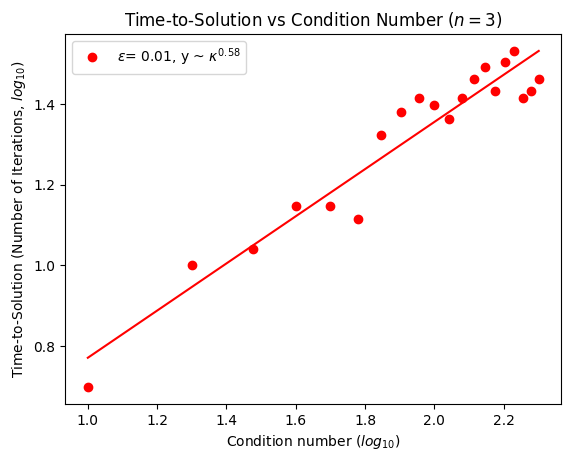

In [ ]:
from scipy.stats import linregress
eta_all = [0.509676, 0.677043, 0.7364305, 0.7668486, 0.7853381, 0.7977654, 0.8066921, 0.81341465, 0.81865975, 0.82286616, 0.82631470, 0.82919322, 0.83163227, 0.83372536, 0.83554122, 0.83713151, 0.838535800, 0.839784920, 0.840903240, 0.841910281]
cond = [     10,       20,       30,        40,        50,        60,        70,        80,         90,         100,        110,        120,        130,        140,        150,        160,        170,         180,         190,         200]
eps = 0.01
vqls = VQLS_Pennylane()
arr_eps = []
for num in range(20):
  arr_k = []
  gamma = (eps**2) / ( 3 * (num+1)*10)
  i = 0
  while(result[num][i] > gamma):
    arr_k += [result[num][i]]
    i+=1
  arr_eps += [arr_k]

nits = list(map(lambda h: len(h)+1, arr_eps))
slope, intercept, r_value, p_value, std_err = linregress(np.log10(cond), np.log10(nits))
xfid = np.linspace(np.log10(10), np.log10(200))
plt.plot(np.log10(cond), np.log10(nits), 'o', color="red", label="$\epsilon$= " + str(eps) + (", y ~ $\kappa^{%.2f}$" % slope))
plt.plot(xfid, xfid*slope + intercept, color="red")
plt.title("Time-to-Solution vs Condition Number ($n=3$)")
plt.xlabel("Condition number ($log_{10}$)")
plt.ylabel("Time-to-Solution (Number of Iterations, $log_{10}$)")
plt.legend()
plt.show()

In [ ]:
result = VQLS_Pennylane(n=4).run().cost_history

n=4
Ising QLSP
Cond = 20
Eps = 0.01
Method = L-BFGS-B
Target = 6.25e-08
Logging cost: 0.00023270651857032476
Logging cost: 0.00015499640495264533
Logging cost: 0.0001359294932719024
Logging cost: 0.00011225732793690435
Logging cost: 0.00011125921376897718
Logging cost: 0.00011058428624466377
Logging cost: 0.0001084380606080626
Logging cost: 0.00010769830503254418
Logging cost: 0.00010743707719812479
Logging cost: 0.00010730532415997862
Logging cost: 0.00010724503242687256
Logging cost: 0.00010707956636057947
Logging cost: 0.00010689017103410192
Logging cost: 0.00010663182839498742
Logging cost: 0.0001062700942485173
Logging cost: 0.00010552586926698693
Logging cost: 0.00010383385747547713
Logging cost: 0.00010160005311010689
Logging cost: 9.943051847299822e-05
Logging cost: 9.416737398287855e-05
Logging cost: 8.762264842138157e-05
Logging cost: 8.432997685731136e-05
Logging cost: 7.878826888302326e-05
Logging cost: 7.487990014820589e-05
Logging cost: 6.688149536332455e-05
Logging cost:

In [ ]:
result = []
result2 = []
w = 0.001 * np.random.randn(3**2)
for k in range(10, 210, 10):
  result2 += [VQLS_Pennylane(cond=k, w=w, n=3, method='Powell').run().cost_history]

n=3
Ising QLSP
Cond = 10
Eps = 0.01
Method = Powell
Target = 3.3333333333333335e-07
Logging cost: 7.564497116252511e-06
Logging cost: 4.226917149630083e-09
Gamma constraint reahed!
n=3
Ising QLSP
Cond = 20
Eps = 0.01
Method = Powell
Target = 8.333333333333334e-08
Logging cost: 3.593808032570367e-05
Logging cost: 2.115339678976369e-07
Logging cost: 1.8362713016806254e-09
Gamma constraint reahed!
n=3
Ising QLSP
Cond = 30
Eps = 0.01
Method = Powell
Target = 3.7037037037037036e-08
Logging cost: 7.356483991827201e-05
Logging cost: 2.4159817987312593e-06
Logging cost: 1.3898984552174198e-07
Logging cost: 2.2342128702668163e-09
Gamma constraint reahed!
n=3
Ising QLSP
Cond = 40
Eps = 0.01
Method = Powell
Target = 2.0833333333333335e-08
Logging cost: 0.00011133780818439742
Logging cost: 9.07925551701938e-06
Logging cost: 1.4924791704729046e-06
Logging cost: 4.114110957464945e-08
Logging cost: 5.0372883642069155e-09
Gamma constraint reahed!
n=3
Ising QLSP
Cond = 50
Eps = 0.01
Method = Powell
Tar

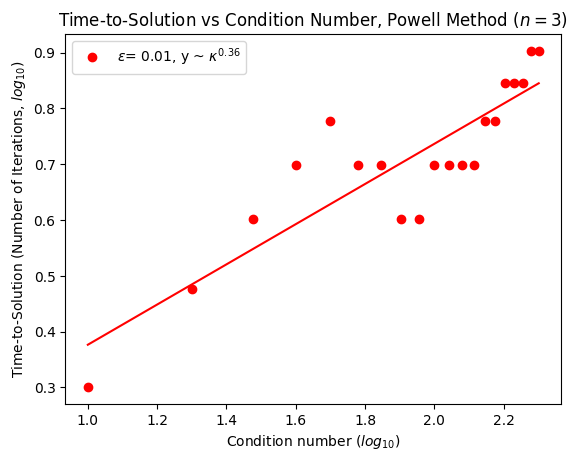

In [ ]:

from scipy.stats import linregress

nits = list(map(lambda h: len(h), result2))
cond = [x for x in range(10, 210, 10)]
slope, intercept, r_value, p_value, std_err = linregress(np.log10(cond), np.log10(nits))
xfid = np.linspace(np.log10(10), np.log10(200))
plt.plot(np.log10(cond), np.log10(nits), 'o', color="red", label="$\epsilon$= " + str(0.01) + (", y ~ $\kappa^{%.2f}$" % slope))
plt.plot(xfid, xfid*slope + intercept, color="red")
plt.title("Time-to-Solution vs Condition Number, Powell Method ($n=3$)")
plt.xlabel("Condition number ($log_{10}$)")
plt.ylabel("Time-to-Solution (Number of Iterations, $log_{10}$)")
plt.legend()
plt.show()
#plt.plot(np.log10(cond), np.log10(nits))